##**Hardware Setting**



In [ ]:
!nvidia-smi

Wed Nov 30 09:06:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##**Import Libraries**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import PIL
import itertools
import cv2
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from IPython.display import Image
import imutils   
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from keras.utils.vis_utils import plot_model
import keras
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

##**Dataset**

In [ ]:
train_dir = '/content/drive/MyDrive/Facial Emotion Recognition/FER2013-4Class/train/'
test_dir= '/content/drive/MyDrive/Facial Emotion Recognition/FER2013-4Class/test/'
classes = os.listdir('/content/drive/MyDrive/Facial Emotion Recognition/FER2013-4Class/train/')
path= {}
for label in classes:
  path[label] = list(map(lambda x: train_dir + label + '/' + x, os.listdir(train_dir + label)))

classes

['fear', 'happy', 'angry']

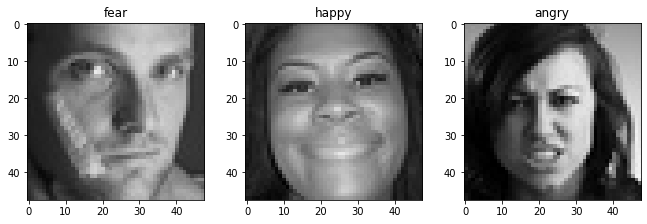

In [ ]:
plt.figure(figsize = (15,15))
index = 0
for label in classes:
  random.shuffle(path[label])
  directory_list = path[label][:5]

  for i in range(2, 3):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(directory_list[i]))
    plt.title(label)

##**Interested labels for traning model with 3 classes**

In [ ]:
Interested_labels= [3, 4, 6]
data = data[data.emotion.isin(Interested_labels)]
data.shape

##**Dataset Distribution**

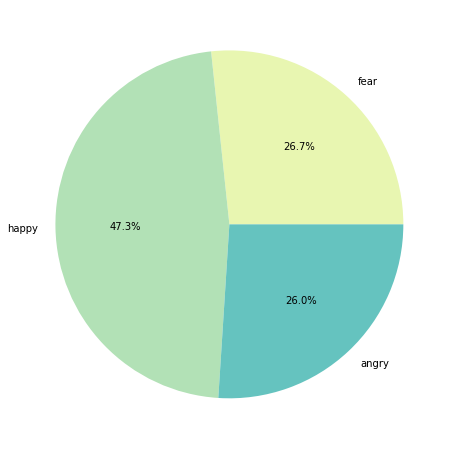

In [ ]:
No_images = []
image_label = []

for i in os.listdir('/content/drive/MyDrive/Facial Emotion Recognition/FER2013-4Class/train/'):
  class_train = os.listdir(os.path.join('/content/drive/MyDrive/Facial Emotion Recognition/FER2013-4Class/train/', i))
  No_images.append(len(class_train))
  image_label.append(i)

plt.figure(figsize=(8, 8))
colors = sns.color_palette('YlGnBu')
plt.pie(No_images, 
        labels = image_label, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

##**Image Preprocessing**

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Facial Emotion Recognition/FER2013-4Class/train/happy/Training_7173508.jpg')
img = cv2.resize(
            img,
            dsize=(48,48),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray1 = cv2.GaussianBlur(gray, (5, 5), 0)

thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh1 = cv2.dilate(thresh, None, iterations=2)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 1)
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 3, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 3, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 3, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 3, (255, 255, 0), -1)

ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

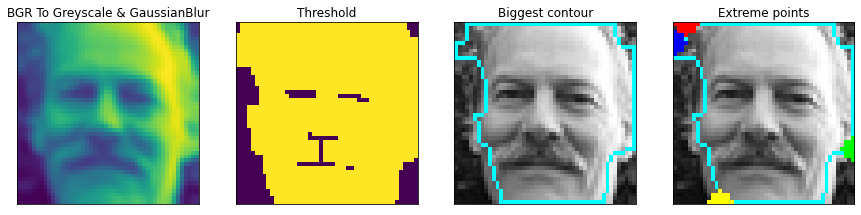

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(gray1)
plt.xticks([])
plt.yticks([])
plt.title('BGR To Greyscale & GaussianBlur')
plt.subplot(142)
plt.imshow(thresh1)
plt.xticks([])
plt.yticks([])
plt.title('Threshold')
plt.subplot(143)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Biggest contour')
plt.subplot(144)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Extreme points')
plt.show()

In [ ]:
def crop_image(image, plot=False):
    
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    #plot
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

Text(0.5, 1.0, 'Cropped  Image')

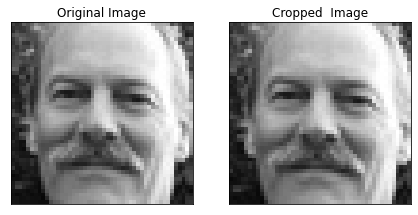

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.subplot(142)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Cropped  Image')

In [ ]:
# Saving Cropped Images 
fear = train_dir + 'fear'
# happy = train_dir + 'happy'
# angry = train_dir + 'angry'

j = 0
for i in tqdm(os.listdir(fear)):
  path = os.path.join(fear, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (48, 48))
    save_path = '/content/drive/MyDrive/Facial Emotion Recognition/Test_Cropped/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1


##**Data Augmentation**

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory('/content/drive/MyDrive/Facial Emotion Recognition/Cropped',
                                         target_size=(48, 48),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('/content/drive/MyDrive/Facial Emotion Recognition/Cropped/',
                                         target_size=(48, 48),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')


test_datagen = ImageDataGenerator(rescale = 1./255)

test_data = datagen.flow_from_directory('/content/drive/MyDrive/Facial Emotion Recognition/test_cropped/',
                                         target_size=(48, 48),
                                        class_mode='categorical',
                                        batch_size=64,
                                        shuffle=False)

Found 3475 images belonging to 3 classes.
Found 868 images belonging to 3 classes.
Found 4740 images belonging to 3 classes.


In [ ]:
# Index of Each Class
print(train_data.class_indices)
print(test_data.class_indices)

{'angry': 0, 'fear': 1, 'happy': 2}
{'angry': 0, 'fear': 1, 'happy': 2}


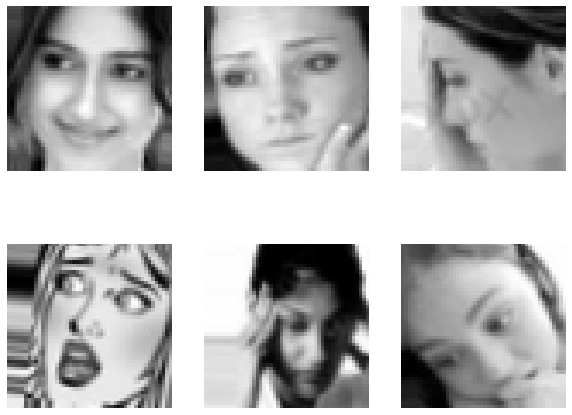

In [ ]:
# Visualized Augmented Data
aug_x, aug_y = next(train_data)
plt.figure(figsize=(10, 8))
for i in range(6):
  plt.subplot(2,3, i+1)
  Augmented = array_to_img(aug_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(Augmented)
plt.show()

##**Checkpoint and EarlyStopping**

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Facial Emotion Recognition/Model_Ckeckpoint/EfficientNetB1.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)


earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)


reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

##**CNN Model with 3Classes**

In [ ]:
input_shape = (48, 48, 1)
output_class = 3

model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
%%time

history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

##**EfficientNet B1 Model**

In [ ]:
EfficientNetB1 = EfficientNetB1(weights='imagenet', 
                        include_top=False, 
                        input_shape=(48, 48,3))

model = EfficientNetB1.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation='softmax')(model)
model = Model(inputs=EfficientNetB1.input, 
              outputs=model)


model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file = 'EfficientNetB1_LayerB1.png', show_shapes = True, show_layer_names = True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, 
epsilon=1e-08, decay=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time

history = model.fit(train_data, 
                    epochs = 30, 
                    validation_data=(valid_data),
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/30
109/109 [==============================] - ETA: 0s - loss: 0.9682 - accuracy: 0.5534
Epoch 1: val_accuracy improved from -inf to 0.05645, saving model to /content/drive/MyDrive/Facial Emotion Recognition/Model_Ckeckpoint/EfficientNetB1.h5
109/109 [==============================] - 866s 8s/step - loss: 0.9682 - accuracy: 0.5534 - val_loss: 1.2793 - val_accuracy: 0.0565 - lr: 1.0000e-04
Epoch 2/30
109/109 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.8317
Epoch 2: val_accuracy improved from 0.05645 to 0.94355, saving model to /content/drive/MyDrive/Facial Emotion Recognition/Model_Ckeckpoint/EfficientNetB1.h5
109/109 [==============================] - 12s 106ms/step - loss: 0.5034 - accuracy: 0.8317 - val_loss: 0.4615 - val_accuracy: 0.9435 - lr: 1.0000e-04
Epoch 3/30
109/109 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.9125
Epoch 3: val_accuracy did not improve from 0.94355
109/109 [==============================] - 11s 101

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

109/109 [==============================] - 7s 66ms/step - loss: 0.2495 - accuracy: 0.9433
Train accuracy & loss: [0.2494623214006424, 0.9433093667030334]


75/75 [==============================] - 624s 8s/step - loss: 0.5883 - accuracy: 0.8637
Test accuracy & loss: [0.588322639465332, 0.8637130856513977]


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# Confusion Matrix
label_test = test_data.classes
label_predict = np.argmax(model.predict(test_data), axis=1)
confusion_matrix = confusion_matrix(label_test, label_predict)
print(confusion_matrix)
plot_confusion_matrix(confusion_matrix, classes, normalize=False)

In [ ]:
# Classification Report
print(classification_report(label_test, label_predict))

In [ ]:
## Predictions on Testing dataset

dict_label = {0: 'angry',
              1: 'fear',
              2: 'happy'}
              
prediction = []
original = []
image = []
count = 0
for i in os.listdir('/content/drive/MyDrive/Facial Emotion Recognition/test_cropped/'):
  for item in os.listdir(os.path.join('/content/drive/MyDrive/Facial Emotion Recognition/test_cropped/', i)):
    img= PIL.Image.open(os.path.join('/content/drive/MyDrive/Facial Emotion Recognition/test_cropped/', i, item))
    image.append(img)
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(dict_label[predict]) 
    original.append(i)

In [ ]:
# Accuracy of Test  
accuracy = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(accuracy))

Test Accuracy : 0.8643459915611814


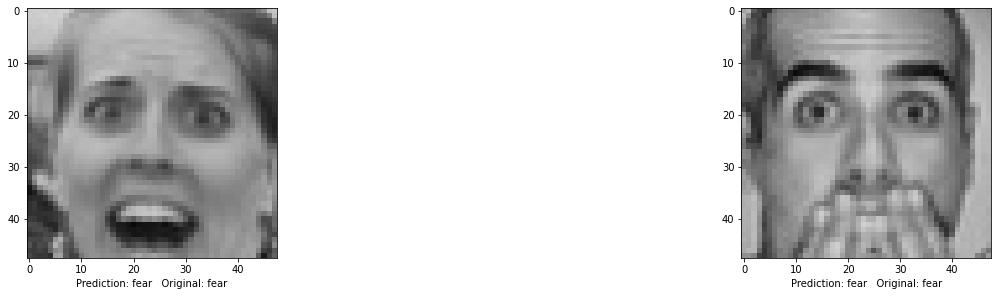

In [ ]:
# Result
fig = plt.figure(figsize = (20, 20))
for i in range(2):
    j = random.randint(0, len(image))
    fig.add_subplot(5, 2, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

*References:*



*  Abhinav Agrawal and Namita Mittal. Using CNN for facial expression recognition: a study of the effects of kernel size and number of filters on accuracy. The Visual Computer, 36(2):405–412, 2020.
* Beat Fasel and Juergen Luettin. Automatic facial expression analysis: a
survey. Pattern recognition, 36(1):259–275, 2003.
* Ning Zhou, Renyu Liang, and Wenqian Shi. A lightweight convolutional
neural network for real-time facial expression detection. IEEE Access,
9:5573–5584, 2020.




